# South Africa

validation PM2.5 CAMS models

* DEM

In [1]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re
import warnings
from collections import defaultdict

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt
import rasterio as rio
from shapely import geometry
from rasterstats import zonal_stats
import seaborn as sns

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GroupKFold
import statistics 

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, AddFeature, MapFeatureTask, MergeFeatureTask, RemoveFeature,LoadTask, SaveTask, OverwritePermission
from sentinelhub import bbox_to_dimensions, bbox_to_resolution
from eolearn.io import ExportToTiff

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)# South Africa

from utils_carles import polygrid, export_geotiff, percs_landuse, upscale_mean_tiff, extract_points_from_raster

In [2]:
DATA_DIR = Path('training_dataset_south_africa')
AOIS = ['South_Africa']

In [3]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

In [4]:
# CHANGE THIS VALUE to True IF PRE-PROCESSING NEEDS TO BE DONE
preproc = True

### Extract predictor data at CAMS 10km

#### Prepare DEM with 10km CAMS

In [17]:
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                            filename='DEM_1km.tif',
                           no_data_value=128)
dem_train_eop

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(614, 656, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((26.56263888888889, -28.18263888888889), (31.747083333333336, -23.24763888888889)), crs=CRS('4326'))
  timestamp: []
)

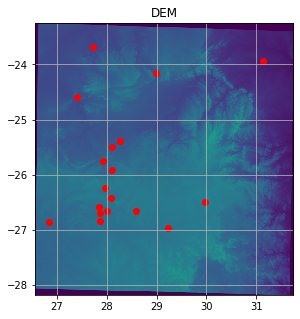

In [18]:
fig, ax = plt.subplots(figsize=(6,5))

draw_feature(ax=ax, eopatch=dem_train_eop, 
             feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
             vmin=0, vmax=4000, cmap=plt.cm.viridis, time_idx=None)
pm25_gt_min.plot(ax=ax, color='r', marker='o');


In [19]:
# Perform zonal statistics - mean altitude per CAMS pixel
src = rio.open(str(dem_train_dir) + '/DEM_1km.tif')
affine = src.transform
array = dem_train_eop.data_timeless['DEM']
array = array[:, :, 0]
dem_grid_10km = CAMS_grid_down
zstats = zonal_stats(dem_grid_10km, array, affine=affine, stats="mean", nodata=np.nan)
vals = []
for index, value in enumerate(zstats):
    vals.append(value['mean'])
    
dem_grid_10km['elevation'] = vals

In [20]:
# Now we can rasterize
minx, miny, maxx, maxy = CAMS_grid_down.geometry.total_bounds
sizey = round((maxy-miny)/res_down)
sizex = round((maxx-minx)/res_down)
transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
shapes = ((geom, value) for geom, value in zip(dem_grid_10km.geometry, dem_grid_10km['elevation']))

dem10km = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
dem10km
export_geotiff(str(dem_train_dir) + '/DEM_CAMS_10km.tif', dem10km, transform, 4326)

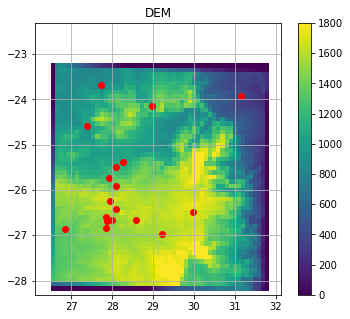

In [21]:
# Read and visualize
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                           filename='DEM_CAMS_10km.tif')

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=dem_train_eop,
                  feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                  time_idx=None,
                  vmin=0, vmax=1800)
pm25_gt_min.plot(ax=ax, color='r', marker='o');
fig.colorbar(fh, ax=ax);

## Prediction

In [71]:
bbox_sa = gpd.read_file('AOIs_bboxes/SouthAfrica/South_Africa_test.shp')

In [47]:
cams_pm25_test_dir = Path('validation_dataset_south_africa/South_Africa/CAMS/PM2_5')
dates_sa_pm25 = pd.read_csv('SA-date-PM25.txt')
dates_sa_pm25

,Day,time
0,2150,h12
1,2153,h12
2,2161,h12
3,2170,h12
4,2178,h12
5,2180,h12
6,2186,h12
7,2190,h12
8,2196,h12
9,2200,h12


In [44]:
day, time = dates_sa_pm25.iloc[0]

In [95]:
## Prepare the test images
input_filenames = []
for index in dates_sa_pm25.index:
    day, time = dates_sa_pm25.iloc[index]
    input_filename = f'CAMS_PM2_5_day{day}_{time.split(" ")[-1]}.tif'
    input_filenames.append(input_filename)

input_filenames

['CAMS_PM2_5_day2150_h12.tif',
 'CAMS_PM2_5_day2153_h12.tif',
 'CAMS_PM2_5_day2161_h12.tif',
 'CAMS_PM2_5_day2170_h12.tif',
 'CAMS_PM2_5_day2178_h12.tif',
 'CAMS_PM2_5_day2180_h12.tif',
 'CAMS_PM2_5_day2186_h12.tif',
 'CAMS_PM2_5_day2190_h12.tif',
 'CAMS_PM2_5_day2196_h12.tif',
 'CAMS_PM2_5_day2200_h12.tif']

#### Extract DEM
Note: 0 values of extracted DEM

In [96]:
# Extract DEM
raster_path = str(dem_train_dir) + '/DEM_CAMS_10km.tif'
dem_10km_df = extract_points_from_raster(CAMS_centroids_down, raster_path, 'DEM')
dem_10km_df = dem_10km_df.dropna()
dem_10km_df = dem_10km_df.drop('raster', 1)

In [97]:
dem_10km_df

,lon,lat,DEM
253,26.567623,-23.249427,0.0
254,26.567623,-23.347787,0.0
255,26.567623,-23.446148,0.0
256,26.567623,-23.544509,0.0
257,26.567623,-23.642869,0.0
...,...,...,...
3532,31.780738,-27.774017,0.0
3533,31.780738,-27.872378,0.0
3534,31.780738,-27.970738,0.0
3535,31.780738,-28.069099,0.0


In [110]:
## Create submission file

submission_dir = Path('test-submission')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(submission_dir/aoi/product):
            os.makedirs(submission_dir/aoi/product)


            
## Create visulization file
visulize_dir = Path('test-visulize')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(visulize_dir/aoi/product):
            os.makedirs(visulize_dir/aoi/product)

#### Predict UPSCALED CAMS VALUES 

In [113]:


bbox_sa.to_crs(epsg=4326, inplace=True)
bbox_sa.to_file('sa-bbox-wgs84.shp', driver='ESRI Shapefile')

test_df = dem_10km_df

for input_filename in input_filenames:
    test_df['day']=np.nan
    test_df['hour']=np.nan
    test_df['dayhour']=""
    
    for i in range(test_df.shape[0]):
        tiff_name = input_filename
        day, hour = tiff_name.split('_day')[-1].split('_')
        test_df.iat[i,test_df.columns.get_loc('day')] = day
        test_df.iat[i,test_df.columns.get_loc('hour')] = hour[1:3]
        test_df.iat[i,test_df.columns.get_loc('dayhour')] = str(day)+str(hour[1:3])
        

    # X inputs
    test_X = np.array(test_df.drop(['day','dayhour'], axis=1))
    
    ## PREDICTION
    predicted_CAMS = rf.predict(test_X)
    
    #test_df['predicted_CAMS'] = predicted_CAMS
    
    ## rastrize
    minx, miny, maxx, maxy = CAMS_grid_down.geometry.total_bounds
    sizey = round((maxy-miny)/res_down)
    sizex = round((maxx-minx)/res_down)
    transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
    shapes = ((geom, value) for geom, value in zip(CAMS_grid_down.geometry, predicted_CAMS))
    upscaled_PM_2_5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
    
    ## export for prediction
    export_geotiff(str(submission_dir) + '/South_Africa/PM2.5/'+f'{day}_PM25_South_Africa.tif', upscaled_PM_2_5, transform, 4326)
    
    mask_tiff('sa-bbox-wgs84.shp', 
              submission_dir/'South_Africa'/'PM2.5'/f'{day}_PM25_South_Africa.tif', 
              submission_dir/'South_Africa'/'PM2.5'/f'{day}_PM25_South_Africa.tif')
    
    ## export them for visualization 
    export_geotiff(str(visulize_dir) + '/South_Africa/PM2.5/'+f'CAMS_PM25_day{day}_{hour}.tif', upscaled_PM_2_5, transform, 4326)
    
    mask_tiff('sa-bbox-wgs84.shp', 
              visulize_dir/'South_Africa'/'PM2.5'/f'CAMS_PM25_day{day}_{hour}.tif', 
              visulize_dir/'South_Africa'/'PM2.5'/f'CAMS_PM25_day{day}_{hour}.tif')
    
    

    

In [115]:
## load upscaled CAMS
upscaled_cams_dir = Path('test-visulize/South_Africa/PM2.5')
upscaled_img = load_tiffs(upscaled_cams_dir,
                          (FeatureType.DATA, 'PM2_5'),
                          offset=OFFSET,
                          data_source='cams')


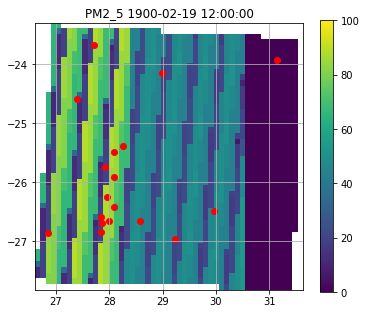

In [134]:

time_idx = 0

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=upscaled_img,
                  feature=(FeatureType.DATA, 'PM2_5'),
                  time_idx=time_idx,
                  vmin=0, vmax=100)
pm25_gt_min.plot(ax=ax, color='r', marker='o');
fig.colorbar(fh, ax=ax);